In [2]:
import os
import re
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from PIL import Image
from torchvision.transforms import Resize
from constants import DATASETS_PATH, CHEXPERT_LABELS

In [3]:
DATA_PATH = DATASETS_PATH['mimic-cxr']
IMAGES_PATH = 'images-normalized'
REPORTS_PATH = 'reports'

## MIMIC Dataset inspection & preprocessing

In [4]:
metadata = pd.read_csv(os.path.join(DATA_PATH, 'mimic-cxr-2.0.0-metadata.csv.gz'), compression='gzip')
print("Number of samples: " + str(len(metadata)))
metadata.head(n=10)

Number of samples: 377110


,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,CHEST (PA AND LAT),PA,3056,2544,21800506,213014.531,CHEST (PA AND LAT),postero-anterior,Erect
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,50414267,CHEST (PA AND LAT),LATERAL,3056,2544,21800506,213014.531,CHEST (PA AND LAT),lateral,Erect
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527,CHEST (PA AND LAT),PA,3056,2544,21800626,165500.312,CHEST (PA AND LAT),postero-anterior,Erect
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,10000032,53189527,CHEST (PA AND LAT),LATERAL,3056,2544,21800626,165500.312,CHEST (PA AND LAT),lateral,Erect
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,CHEST (PORTABLE AP),AP,2705,2539,21800723,80556.875,CHEST (PORTABLE AP),antero-posterior,NaN
5,fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818,10000032,53911762,CHEST (PORTABLE AP),AP,2906,2258,21800723,80556.875,CHEST (PORTABLE AP),antero-posterior,Erect
6,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,10000032,56699142,CHEST (PORTABLE AP),AP,3056,2544,21800805,234424.765,CHEST (PORTABLE AP),antero-posterior,NaN
7,096052b7-d256dc40-453a102b-fa7d01c6-1b22c6b4,10000764,57375967,CHEST (PA AND LAT),AP,2544,3056,21321015,84047.984,CHEST (PA AND LAT),antero-posterior,Erect
8,b79e55c3-735ce5ac-64412506-cdc9ea79-f1af521f,10000764,57375967,CHEST (PA AND LAT),LATERAL,3056,2544,21321015,84047.984,CHEST (PA AND LAT),lateral,Erect
9,dcfeeac4-1597e318-d0e6736a-8b2c2238-47ac3f1b,10000764,57375967,CHEST (PA AND LAT),LATERAL,3056,2544,21321015,84047.984,CHEST (PA AND LAT),lateral,Erect


In [4]:
mimic_df = pd.read_csv(f'{DATA_PATH}/mimic-cxr-2.0.0-split.csv.gz', compression='gzip')

print("Number of samples: " + str(len(mimic_df)))
mimic_df.head(n=20)

Number of samples: 227827


,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN
5,10000898,50771383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6,10000898,54205396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
7,10000935,50578979,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,NaN,1.0,NaN,1.0,NaN,NaN
8,10000935,51178377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,-1.0,NaN,NaN
9,10000935,55697293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [11]:
chexpert_df = pd.read_csv(f'{DATA_PATH}/mimic-cxr-2.0.0-chexpert.csv.gz', compression='gzip')

print("Number of samples: " + str(len(chexpert_df)))
chexpert_df.head(n=20)

Number of samples: 227827


,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN
5,10000898,50771383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6,10000898,54205396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
7,10000935,50578979,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,NaN,1.0,NaN,1.0,NaN,NaN
8,10000935,51178377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,-1.0,NaN,NaN
9,10000935,55697293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [6]:
def merge_image_reports(root_path: str, images_rel_path: str = IMAGES_PATH, reports_rel_path: str = REPORTS_PATH) -> pd.DataFrame:
    data = []
    images_path = os.path.join(root_path, images_rel_path)
    reports_path = os.path.join(root_path, reports_rel_path)

    for p_folder in sorted(os.listdir(images_path)):

        p_path = os.path.join(images_path, p_folder)
        if not os.path.isdir(p_path):
            continue

        for subject_id in os.listdir(p_path):
            subject_path = os.path.join(p_path, subject_id)
            if not os.path.isdir(subject_path):
                continue

            for study_id in os.listdir(subject_path):
                study_path = os.path.join(subject_path, study_id)
                if not os.path.isdir(study_path):
                    continue

                report_txt = os.path.join(reports_path, p_folder, subject_id, f"{study_id}.txt")
                if not os.path.isfile(report_txt):
                    print(f"Report file not found: {report_txt}")
                    continue

                for image_filename in os.listdir(study_path):
                    if not image_filename.endswith(".jpg"):
                        continue

                    dicom_id = os.path.splitext(image_filename)[0]
                    image_path = os.path.join(p_folder, subject_id, study_id, image_filename)
                    report_path = os.path.join(p_folder, subject_id, f"{study_id}.txt")

                    data.append({
                        'dicom_id': dicom_id,
                        'study_id': study_id,
                        'subject_id': subject_id,
                        'image_path': image_path,
                        'report_path': report_path,
                    })

    return pd.DataFrame(data)

Number of samples: 226715


,dicom_id,study_id,subject_id,image_path,report_path
0,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,s53189527,p10000032,p10/p10000032/s53189527/2a2277a9-b0ded155-c0de...,p10/p10000032/s53189527.txt
1,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,s53189527,p10000032,p10/p10000032/s53189527/e084de3b-be89b11e-20fe...,p10/p10000032/s53189527.txt
2,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,s50414267,p10000032,p10/p10000032/s50414267/02aa804e-bde0afdd-112c...,p10/p10000032/s50414267.txt
3,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,s50414267,p10000032,p10/p10000032/s50414267/174413ec-4ec4c1f7-34ea...,p10/p10000032/s50414267.txt
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,s53911762,p10000032,p10/p10000032/s53911762/68b5c4b1-227d0485-9cc3...,p10/p10000032/s53911762.txt
5,fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818,s53911762,p10000032,p10/p10000032/s53911762/fffabebf-74fd3a1f-673b...,p10/p10000032/s53911762.txt
6,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,s56699142,p10000032,p10/p10000032/s56699142/ea030e7a-2e3b1346-bc51...,p10/p10000032/s56699142.txt
7,096052b7-d256dc40-453a102b-fa7d01c6-1b22c6b4,s57375967,p10000764,p10/p10000764/s57375967/096052b7-d256dc40-453a...,p10/p10000764/s57375967.txt
8,b79e55c3-735ce5ac-64412506-cdc9ea79-f1af521f,s57375967,p10000764,p10/p10000764/s57375967/b79e55c3-735ce5ac-6441...,p10/p10000764/s57375967.txt
9,dcfeeac4-1597e318-d0e6736a-8b2c2238-47ac3f1b,s57375967,p10000764,p10/p10000764/s57375967/dcfeeac4-1597e318-d0e6...,p10/p10000764/s57375967.txt


In [ ]:
def merge_labels(image_report_df: pd.DataFrame, labels_df: pd.DataFrame) -> pd.DataFrame:
    labels_df = labels_df.copy()
    labels_df['subject_id'] = labels_df['subject_id'].apply(lambda x: f'p{x}')
    labels_df['study_id'] = labels_df['study_id'].apply(lambda x: f's{x}')

    merged_df = pd.merge(
        image_report_df,
        labels_df,
        how='inner',
        on=['subject_id', 'study_id']
    )
    return merged_df

In [10]:
def assign_splits(image_report_labels_df: pd.DataFrame, split_df: pd.DataFrame) -> pd.DataFrame:
    split_df = split_df.copy()
    split_df['subject_id'] = split_df['subject_id'].apply(lambda x: f'p{x}')
    split_df['study_id'] = split_df['study_id'].apply(lambda x: f's{x}')

    merged_df = pd.merge(
        image_report_labels_df,
        split_df,
        how='inner',
        on=['dicom_id', 'subject_id', 'study_id']
    )
    return merged_df

Number of samples: 226707


,dicom_id,study_id,subject_id,image_path,report_path,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,split
0,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,s53189527,p10000032,p10/p10000032/s53189527/2a2277a9-b0ded155-c0de...,p10/p10000032/s53189527.txt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,train
1,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,s53189527,p10000032,p10/p10000032/s53189527/e084de3b-be89b11e-20fe...,p10/p10000032/s53189527.txt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,train
2,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,s50414267,p10000032,p10/p10000032/s50414267/02aa804e-bde0afdd-112c...,p10/p10000032/s50414267.txt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,train
3,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,s50414267,p10000032,p10/p10000032/s50414267/174413ec-4ec4c1f7-34ea...,p10/p10000032/s50414267.txt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,train
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,s53911762,p10000032,p10/p10000032/s53911762/68b5c4b1-227d0485-9cc3...,p10/p10000032/s53911762.txt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,train
5,fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818,s53911762,p10000032,p10/p10000032/s53911762/fffabebf-74fd3a1f-673b...,p10/p10000032/s53911762.txt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,train
6,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,s56699142,p10000032,p10/p10000032/s56699142/ea030e7a-2e3b1346-bc51...,p10/p10000032/s56699142.txt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,train
7,096052b7-d256dc40-453a102b-fa7d01c6-1b22c6b4,s57375967,p10000764,p10/p10000764/s57375967/096052b7-d256dc40-453a...,p10/p10000764/s57375967.txt,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,train
8,b79e55c3-735ce5ac-64412506-cdc9ea79-f1af521f,s57375967,p10000764,p10/p10000764/s57375967/b79e55c3-735ce5ac-6441...,p10/p10000764/s57375967.txt,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,train
9,dcfeeac4-1597e318-d0e6736a-8b2c2238-47ac3f1b,s57375967,p10000764,p10/p10000764/s57375967/dcfeeac4-1597e318-d0e6...,p10/p10000764/s57375967.txt,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,train


In [17]:
def extract_findings_impressions(report_path: str) -> tuple:
    findings, impressions = '', ''
    try:
        with open(report_path, 'r') as file:
            text = file.read()

            findings_match = re.search(r'FINDINGS:\s*(.*?)(?:IMPRESSION:|\Z)', text, re.DOTALL | re.IGNORECASE)
            if findings_match:
                findings = findings_match.group(1).strip()

            impressions_match = re.search(r'IMPRESSION:\s*(.*)', text, re.DOTALL | re.IGNORECASE)
            if impressions_match:
                impressions = impressions_match.group(1).strip()

    except Exception as e:
        print(f"Error reading report {report_path}: {e}")

    return findings, impressions

def map_findings_impressions(mimic_df: pd.DataFrame) -> pd.DataFrame:
    findings_list, impressions_list = [], []
    for _, row in mimic_df.iterrows():
        report_path = os.path.join(DATA_PATH, REPORTS_PATH, row['report_path'])
        findings, impressions = extract_findings_impressions(report_path)
        findings_list.append(findings)
        impressions_list.append(impressions)

    mimic_df['findings'] = findings_list
    mimic_df['impression'] = impressions_list
    return mimic_df

Number of samples: 226707


,dicom_id,study_id,subject_id,image_path,report_path,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,...,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,split,findings,impression
0,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,s53189527,p10000032,p10/p10000032/s53189527/2a2277a9-b0ded155-c0de...,p10/p10000032/s53189527.txt,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,train,"The cardiac, mediastinal and hilar contours ar...",No acute cardiopulmonary abnormality.
1,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,s53189527,p10000032,p10/p10000032/s53189527/e084de3b-be89b11e-20fe...,p10/p10000032/s53189527.txt,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,train,"The cardiac, mediastinal and hilar contours ar...",No acute cardiopulmonary abnormality.
2,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,s50414267,p10000032,p10/p10000032/s50414267/02aa804e-bde0afdd-112c...,p10/p10000032/s50414267.txt,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,train,"There is no focal consolidation, pleural effus...",No acute cardiopulmonary process.
3,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,s50414267,p10000032,p10/p10000032/s50414267/174413ec-4ec4c1f7-34ea...,p10/p10000032/s50414267.txt,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,train,"There is no focal consolidation, pleural effus...",No acute cardiopulmonary process.
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,s53911762,p10000032,p10/p10000032/s53911762/68b5c4b1-227d0485-9cc3...,p10/p10000032/s53911762.txt,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,train,Single frontal view of the chest provided.\n \...,No acute intrathoracic process.
5,fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818,s53911762,p10000032,p10/p10000032/s53911762/fffabebf-74fd3a1f-673b...,p10/p10000032/s53911762.txt,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,train,Single frontal view of the chest provided.\n \...,No acute intrathoracic process.
6,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,s56699142,p10000032,p10/p10000032/s56699142/ea030e7a-2e3b1346-bc51...,p10/p10000032/s56699142.txt,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,train,"The lungs are clear of focal consolidation, pl...",No acute cardiopulmonary process.
7,096052b7-d256dc40-453a102b-fa7d01c6-1b22c6b4,s57375967,p10000764,p10/p10000764/s57375967/096052b7-d256dc40-453a...,p10/p10000764/s57375967.txt,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,train,PA and lateral views of the chest provided. ...,"Focal consolidation at the left lung base, pos..."
8,b79e55c3-735ce5ac-64412506-cdc9ea79-f1af521f,s57375967,p10000764,p10/p10000764/s57375967/b79e55c3-735ce5ac-6441...,p10/p10000764/s57375967.txt,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,train,PA and lateral views of the chest provided. ...,"Focal consolidation at the left lung base, pos..."
9,dcfeeac4-1597e318-d0e6736a-8b2c2238-47ac3f1b,s57375967,p10000764,p10/p10000764/s57375967/dcfeeac4-1597e318-d0e6...,p10/p10000764/s57375967.txt,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,train,PA and lateral views of the chest provided. ...,"Focal consolidation at the left lung base, pos..."


## Data visualization

In [1]:
from utils.preprocessor import MimicCXRPreprocessor

mimic_preprocessor = MimicCXRPreprocessor()
preprocessed_mimic_df = mimic_preprocessor.preprocess()

print("Number of samples: " + str(len(preprocessed_mimic_df)))
preprocessed_mimic_df.head(n=20)

Missing study_ids (not in CheXpert labels): {('p12632853', 's50798377'), ('p17603668', 's53607029'), ('p16175671', 's56724958'), ('p15774521', 's53071062'), ('p14463099', 's54168089'), ('p16312859', 's54231141'), ('p11573679', 's58235663')}
Number of samples: 299061


,dicom_id,study_id,subject_id,image_path,report_path,findings,impression,Atelectasis,Cardiomegaly,Consolidation,...,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,split
0,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,s53189527,p10000032,p10/p10000032/s53189527/2a2277a9-b0ded155-c0de...,p10/p10000032/s53189527.txt,"The cardiac, mediastinal and hilar contours ar...",No acute cardiopulmonary abnormality.,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
1,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,s53189527,p10000032,p10/p10000032/s53189527/e084de3b-be89b11e-20fe...,p10/p10000032/s53189527.txt,"The cardiac, mediastinal and hilar contours ar...",No acute cardiopulmonary abnormality.,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
2,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,s50414267,p10000032,p10/p10000032/s50414267/174413ec-4ec4c1f7-34ea...,p10/p10000032/s50414267.txt,"There is no focal consolidation, pleural effus...",No acute cardiopulmonary process.,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
3,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,s53911762,p10000032,p10/p10000032/s53911762/68b5c4b1-227d0485-9cc3...,p10/p10000032/s53911762.txt,Single frontal view of the chest provided.\n \...,No acute intrathoracic process.,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
4,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,s56699142,p10000032,p10/p10000032/s56699142/ea030e7a-2e3b1346-bc51...,p10/p10000032/s56699142.txt,"The lungs are clear of focal consolidation, pl...",No acute cardiopulmonary process.,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
5,096052b7-d256dc40-453a102b-fa7d01c6-1b22c6b4,s57375967,p10000764,p10/p10000764/s57375967/096052b7-d256dc40-453a...,p10/p10000764/s57375967.txt,PA and lateral views of the chest provided. ...,"Focal consolidation at the left lung base, pos...",0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,train
6,b79e55c3-735ce5ac-64412506-cdc9ea79-f1af521f,s57375967,p10000764,p10/p10000764/s57375967/b79e55c3-735ce5ac-6441...,p10/p10000764/s57375967.txt,PA and lateral views of the chest provided. ...,"Focal consolidation at the left lung base, pos...",0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,train
7,dcfeeac4-1597e318-d0e6736a-8b2c2238-47ac3f1b,s57375967,p10000764,p10/p10000764/s57375967/dcfeeac4-1597e318-d0e6...,p10/p10000764/s57375967.txt,PA and lateral views of the chest provided. ...,"Focal consolidation at the left lung base, pos...",0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,train
8,ad13cf84-62c34a01-a01b9e87-2581a359-83bbc046,s56164612,p10000935,p10/p10000935/s56164612/ad13cf84-62c34a01-a01b...,p10/p10000935/s56164612.txt,Lung volumes are low. The heart size is norma...,"New nodular opacities within both upper lobes,...",0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,train
9,8e3f2822-0c1d4b71-2a265bbf-5b96e531-ccf5fa30,s56164612,p10000935,p10/p10000935/s56164612/8e3f2822-0c1d4b71-2a26...,p10/p10000935/s56164612.txt,Lung volumes are low. The heart size is norma...,"New nodular opacities within both upper lobes,...",0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,train


In [12]:
missing_report_df = preprocessed_mimic_df[preprocessed_mimic_df['findings'].str.strip().eq('') & preprocessed_mimic_df['impression'].str.strip().eq('')]
print("Number of samples without text: " + str(len(missing_report_df)))

Number of samples without text: 0


In [2]:
def plot_class_distribution(df, title):
    label_counts = {label: df[label].replace(-1, 1).sum() for label in CHEXPERT_LABELS}

    print("Label counts:")
    for label, count in label_counts.items():
        print(f"{label}: {int(count)}")

    plt.figure(figsize=(12, 6))
    plt.bar(label_counts.keys(), label_counts.values())
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Number of Samples")
    plt.title(f"Number of Positive Samples per Class: {title}")
    plt.tight_layout()
    plt.show()

Split train size: 250744
Label counts:
Atelectasis: 53201
Cardiomegaly: 48092
Consolidation: 14037
Edema: 36814
Enlarged Cardiomediastinum: 14942
Fracture: 5811
Lung Lesion: 8478
Lung Opacity: 54176
No Finding: 96062
Pleural Effusion: 56062
Pleural Other: 3309
Pneumonia: 36550
Pneumothorax: 10489
Support Devices: 55759


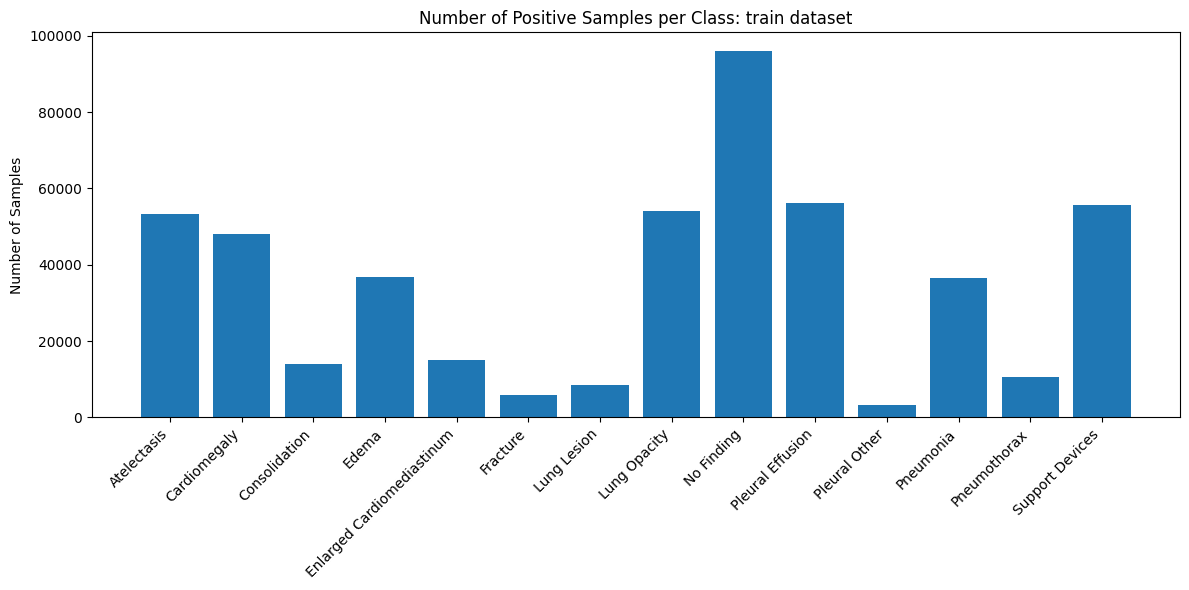

Split val size: 44250
Label counts:
Atelectasis: 9372
Cardiomegaly: 8451
Consolidation: 2455
Edema: 6514
Enlarged Cardiomediastinum: 2607
Fracture: 1016
Lung Lesion: 1468
Lung Opacity: 9624
No Finding: 16953
Pleural Effusion: 9837
Pleural Other: 557
Pneumonia: 6505
Pneumothorax: 1841
Support Devices: 9840


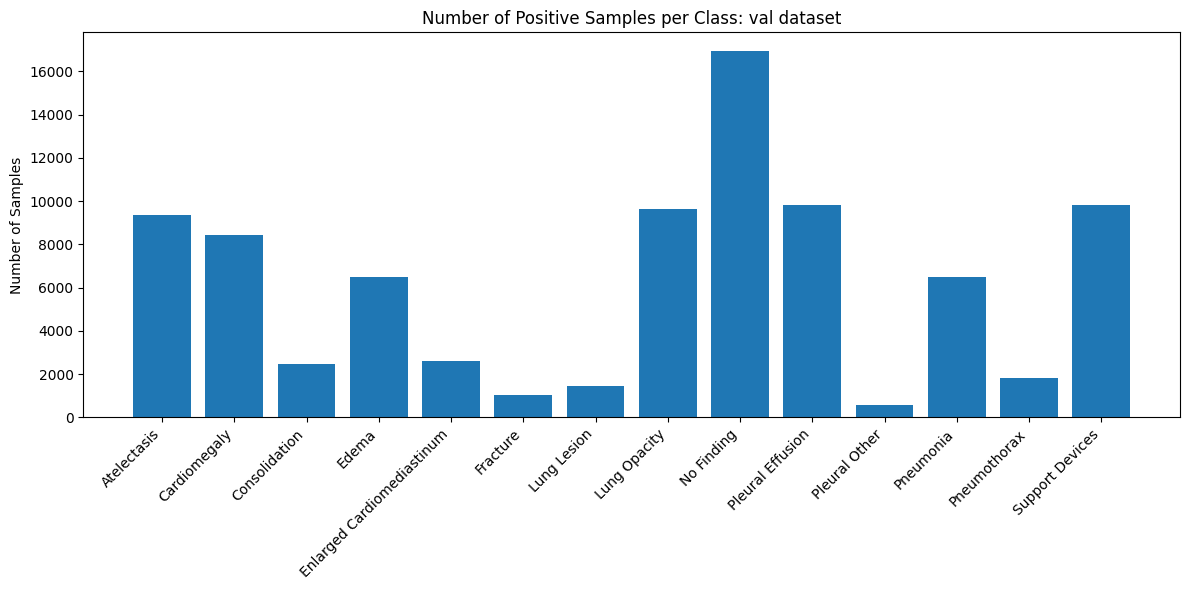

Split test size: 4067
Label counts:
Atelectasis: 1029
Cardiomegaly: 1144
Consolidation: 380
Edema: 1126
Enlarged Cardiomediastinum: 394
Fracture: 98
Lung Lesion: 182
Lung Opacity: 1356
No Finding: 741
Pleural Effusion: 1393
Pleural Other: 132
Pneumonia: 890
Pneumothorax: 154
Support Devices: 1155


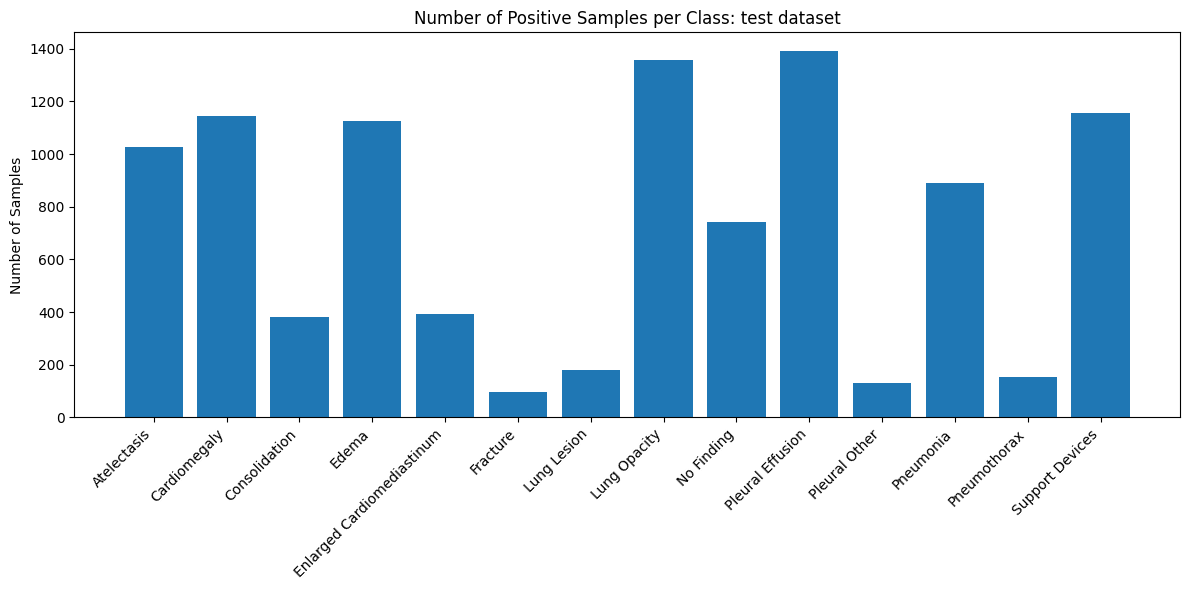

In [6]:
for split in ['train', 'val', 'test']:
    split_df = preprocessed_mimic_df[preprocessed_mimic_df['split'] == split]
    print(f"Split {split} size: {len(split_df)}")
    plot_class_distribution(split_df, f"{split} dataset")

In [7]:
# Save the processed dataset
train_split = preprocessed_mimic_df[preprocessed_mimic_df['split'] == 'train']
val_split = preprocessed_mimic_df[preprocessed_mimic_df['split'] == 'val']
test_split = preprocessed_mimic_df[preprocessed_mimic_df['split'] == 'test']

print("Number of train samples: " + str(len(train_split)))
print("Number of val samples: " + str(len(val_split)))
print("Number of test samples: " + str(len(test_split)))

Number of train samples: 250744
Number of val samples: 44250
Number of test samples: 4067


In [9]:
preprocessed_mimic_df.to_csv(f'{DATA_PATH}/processed/mimic-cxr_processed.csv', index=False)
train_split.to_csv(f'{DATA_PATH}/processed/mimic-cxr_train.csv', index=False)
val_split.to_csv(f'{DATA_PATH}/processed/mimic-cxr_val.csv', index=False)
test_split.to_csv(f'{DATA_PATH}/processed/mimic-cxr_test.csv', index=False)

In [1]:
# Test loading from S3 bucket
from utils.minio import MinioUtils

object_path = 'mimic-cxr/processed/mimic-cxr_processed.csv'
mimic_s3_df = MinioUtils.load_csv_from_minio(object_path)

print("Number of samples: " + str(len(mimic_s3_df)))
mimic_s3_df.head(n=20)

/Users/tudormihaita/PycharmProjects/clip-cxr-report-gen/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Number of samples: 261697


,dicom_id,study_id,subject_id,image_path,report_path,findings,impression,Atelectasis,Cardiomegaly,Consolidation,...,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,split
0,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,s53189527,p10000032,p10/p10000032/s53189527/2a2277a9-b0ded155-c0de...,p10/p10000032/s53189527.txt,"The cardiac, mediastinal and hilar contours ar...",No acute cardiopulmonary abnormality.,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
1,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,s53189527,p10000032,p10/p10000032/s53189527/e084de3b-be89b11e-20fe...,p10/p10000032/s53189527.txt,"The cardiac, mediastinal and hilar contours ar...",No acute cardiopulmonary abnormality.,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
2,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,s50414267,p10000032,p10/p10000032/s50414267/02aa804e-bde0afdd-112c...,p10/p10000032/s50414267.txt,"There is no focal consolidation, pleural effus...",No acute cardiopulmonary process.,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
3,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,s50414267,p10000032,p10/p10000032/s50414267/174413ec-4ec4c1f7-34ea...,p10/p10000032/s50414267.txt,"There is no focal consolidation, pleural effus...",No acute cardiopulmonary process.,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,s53911762,p10000032,p10/p10000032/s53911762/68b5c4b1-227d0485-9cc3...,p10/p10000032/s53911762.txt,Single frontal view of the chest provided.\n \...,No acute intrathoracic process.,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
5,fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818,s53911762,p10000032,p10/p10000032/s53911762/fffabebf-74fd3a1f-673b...,p10/p10000032/s53911762.txt,Single frontal view of the chest provided.\n \...,No acute intrathoracic process.,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
6,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,s56699142,p10000032,p10/p10000032/s56699142/ea030e7a-2e3b1346-bc51...,p10/p10000032/s56699142.txt,"The lungs are clear of focal consolidation, pl...",No acute cardiopulmonary process.,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
7,096052b7-d256dc40-453a102b-fa7d01c6-1b22c6b4,s57375967,p10000764,p10/p10000764/s57375967/096052b7-d256dc40-453a...,p10/p10000764/s57375967.txt,PA and lateral views of the chest provided. ...,"Focal consolidation at the left lung base, pos...",0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,train
8,b79e55c3-735ce5ac-64412506-cdc9ea79-f1af521f,s57375967,p10000764,p10/p10000764/s57375967/b79e55c3-735ce5ac-6441...,p10/p10000764/s57375967.txt,PA and lateral views of the chest provided. ...,"Focal consolidation at the left lung base, pos...",0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,train
9,8e3f2822-0c1d4b71-2a265bbf-5b96e531-ccf5fa30,s56164612,p10000935,p10/p10000935/s56164612/8e3f2822-0c1d4b71-2a26...,p10/p10000935/s56164612.txt,Lung volumes are low. The heart size is norma...,"New nodular opacities within both upper lobes,...",0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,train


## CXR images resizing

In [3]:
def get_mimic_split_size(root_dir: str, file_ext: str = ".jpg"):
    total_bytes = 0
    for dirpath, _, filenames in os.walk(root_dir):
        for fname in filenames:
            if fname.lower().endswith(file_ext):
                fpath = os.path.join(dirpath, fname)
                total_bytes += os.path.getsize(fpath)

    return total_bytes / (1024 ** 3)

In [7]:
split_path = f'{DATA_PATH}/images'
original_size_gb = get_mimic_split_size(split_path)
print(f"Original size: {original_size_gb:.2f} GB")

Original size: 398.96 GB


In [4]:
def resize_and_save_images(source_root: str, dest_root: str, new_size: tuple = (256, 256), p_folders_to_process: list = None):
    for p_folder in sorted(os.listdir(source_root)):
        if p_folders_to_process is not None and p_folder not in p_folders_to_process:
            continue

        p_path = os.path.join(source_root, p_folder)
        if not os.path.isdir(p_path):
            continue

        for subject_id in os.listdir(p_path):
            subject_path = os.path.join(p_path, subject_id)
            if not os.path.isdir(subject_path):
                continue

            for study_id in os.listdir(subject_path):
                study_path = os.path.join(subject_path, study_id)
                if not os.path.isdir(study_path):
                    continue

                for image_filename in os.listdir(study_path):
                    if not image_filename.endswith(".jpg"):
                        continue

                    src_image_path = os.path.join(study_path, image_filename)
                    dest_image_path = os.path.join(dest_root, p_folder, subject_id, study_id, image_filename)

                    os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

                    try:
                        img = Image.open(src_image_path).convert('RGB')
                        img_resized = Resize(new_size, interpolation=transforms.InterpolationMode.LANCZOS, antialias=True)(img)
                        img_resized.save(dest_image_path)
                    except Exception as e:
                        print(f"Failed to process image {src_image_path}: {e}")

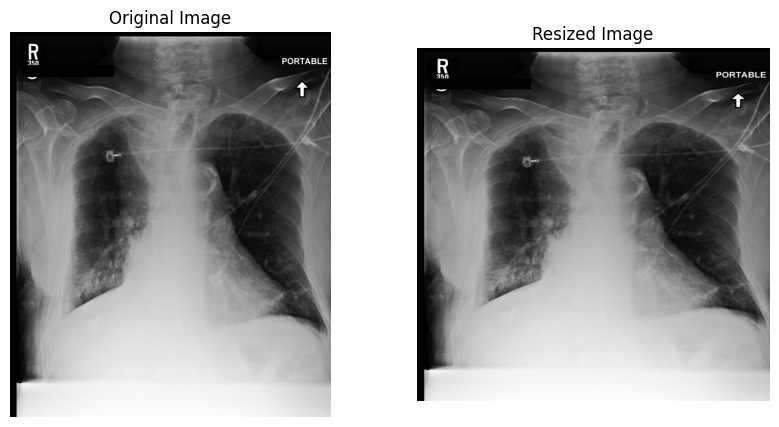

In [28]:
sample_path = mimic_processed_df.sample(1)['image_path'].values[0]
sample_path = os.path.join(DATA_PATH, IMAGES_PATH, sample_path)

sample_image = Image.open(sample_path).convert('RGB')

resized_sample_image = sample_image.resize((1024, 1024), Image.Resampling.LANCZOS)
resized_sample_torch = Resize((1024, 1024), interpolation=transforms.InterpolationMode.LANCZOS, antialias=True)(sample_image)

# resized_sample_image.save(os.path.join(DATA_PATH, 'test1.jpg'))
# resized_sample_torch.save(os.path.join(DATA_PATH, 'test2.jpg'))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample_image)
ax[0].axis('off')
ax[0].set_title('Original Image')
ax[1].imshow(resized_sample_image)
ax[1].axis('off')
ax[1].set_title('Resized Image')
plt.show()

In [30]:
RESIZED_IMAGES_PATH = os.path.join(DATA_PATH, 'images-normalized')
os.makedirs(RESIZED_IMAGES_PATH, exist_ok=True)

resize_and_save_images(os.path.join(DATA_PATH, 'images'), RESIZED_IMAGES_PATH, new_size=(1024, 1024), p_folders_to_process=['p10'])
resized_size_gb = get_mimic_split_size(RESIZED_IMAGES_PATH)
print(f"Resized size: {resized_size_gb:.2f} GB")

Resized size: 3.10 GB


In [31]:
resize_and_save_images(os.path.join(DATA_PATH, 'images'), RESIZED_IMAGES_PATH, new_size=(1024, 1024), p_folders_to_process=['p11', 'p12', 'p13'])
resized_size_gb = get_mimic_split_size(RESIZED_IMAGES_PATH)
print(f"Resized size: {resized_size_gb:.2f} GB")

Resized size: 12.73 GB


In [34]:
RESIZED_IMAGES_PATH = os.path.join(DATA_PATH, 'images-normalized')
resize_and_save_images(os.path.join(DATA_PATH, 'images'), RESIZED_IMAGES_PATH, new_size=(1024, 1024), p_folders_to_process=['p14', 'p15', 'p16'])
resized_size_gb = get_mimic_split_size(RESIZED_IMAGES_PATH)
print(f"Resized size: {resized_size_gb:.2f} GB")

Failed to process image /Volumes/T7 Shield/mimic-cxr/images/p16/p16957952/s52307593/._a48bf7b6-c93b1844-01b1bec5-5155cdfa-b8313093.jpg: cannot identify image file '/Volumes/T7 Shield/mimic-cxr/images/p16/p16957952/s52307593/._a48bf7b6-c93b1844-01b1bec5-5155cdfa-b8313093.jpg'
Resized size: 22.35 GB


In [5]:
RESIZED_IMAGES_PATH = os.path.join(DATA_PATH, 'images-normalized')
resize_and_save_images(os.path.join(DATA_PATH, 'images'), RESIZED_IMAGES_PATH, new_size=(1024, 1024), p_folders_to_process=['p17'])
resized_size_gb = get_mimic_split_size(RESIZED_IMAGES_PATH)
print(f"Resized size: {resized_size_gb:.2f} GB")

Resized size: 24.54 GB


### Preprocessing improvements

In [1]:
from utils.preprocessor import MimicCXRPreprocessor

mimic_preprocessor = MimicCXRPreprocessor()
test_mimic_df = mimic_preprocessor.preprocess()

Missing study_ids (not in chexpert labels): {('p12632853', 's50798377'), ('p14463099', 's54168089'), ('p11573679', 's58235663'), ('p15774521', 's53071062'), ('p16312859', 's54231141'), ('p16175671', 's56724958')}


In [5]:
print("Number of samples with text: " + str(len(test_mimic_df)))

Number of samples with text: 261697


In [31]:
train_split = test_mimic_df[test_mimic_df['split'] == 'train']
val_split = test_mimic_df[test_mimic_df['split'] == 'val']
test_split = test_mimic_df[test_mimic_df['split'] == 'test']

print("Number of train samples: " + str(len(train_split)))
print("Number of val samples: " + str(len(val_split)))
print("Number of test samples: " + str(len(test_split)))

test_mimic_df.to_csv(f'{DATA_PATH}/processed/mimic-cxr_processed.csv', index=False)
train_split.to_csv(f'{DATA_PATH}/processed/mimic-cxr_train.csv', index=False)
val_split.to_csv(f'{DATA_PATH}/processed/mimic-cxr_val.csv', index=False)
test_split.to_csv(f'{DATA_PATH}/processed/mimic-cxr_test.csv', index=False)

Number of train samples: 219271
Number of val samples: 38696
Number of test samples: 3730


In [27]:
missing_text_df = test_mimic_df[test_mimic_df['findings'].str.strip().eq('') & test_mimic_df['impression'].str.strip().eq('')]
print("Number of samples without text: " + str(len(missing_text_df)))

Number of samples without text: 0


In [ ]:
for split in ['train', 'val', 'test']:
    split_df = test_mimic_df[test_mimic_df['split'] == split]
    print(f"Split {split} size: {len(split_df)}")
    plot_class_distribution(split_df, f"{split} dataset")

## CXR-PRO data enrichment

In [5]:
REPORTS_CLEANED_PATH = 'reports-cxr-pro'
reports_path = os.path.join(DATA_PATH, REPORTS_CLEANED_PATH)

train_reports = pd.read_csv(f'{reports_path}/mimic_train_impressions.csv')
test_reports = pd.read_csv(f'{reports_path}/mimic_test_impressions.csv')

print("Number of train samples: " + str(len(train_reports)))
print("Number of test samples: " + str(len(test_reports)))
train_reports.head(n=100)

Number of train samples: 371951
Number of test samples: 2188


,dicom_id,study_id,subject_id,report
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,50414267,10000032,No acute cardiopulmonary process.
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,50414267,10000032,No acute cardiopulmonary process.
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,53189527,10000032,No acute cardiopulmonary abnormality.
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,53189527,10000032,No acute cardiopulmonary abnormality.
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,53911762,10000032,No acute intrathoracic process.
...,...,...,...,...
95,02e759a5-72ab444e-581216c8-af8fea64-8b1a744b,55333410,10001884,No acute findings. Top - normal heart size.
96,5b135035-4708084f-3bb6d230-9db72889-2aa90c14,55333410,10001884,No acute findings. Top - normal heart size.
97,4c3fdd2f-79be0bc9-f5a0ed41-3c9dc58e-75a6d19a,55893591,10001884,No evidence of pneumonia. No acute cardiopulmo...
98,8d4eb7a8-0d3c4f7e-fed33834-ef1c6ffd-e01d0967,55893591,10001884,No evidence of pneumonia. No acute cardiopulmo...


In [6]:
train_reports['split'] = 'train'
test_reports['split'] = 'test'

combined_reports = pd.concat([train_reports, test_reports], ignore_index=True)

print("Number of samples: " + str(len(combined_reports)))
# combined_reports.to_csv(f'{reports_path}/mimic-cxr-pro-impressions.csv', index=False)

Number of samples: 374139


In [9]:
combined_reports.fillna({'report': ''}, inplace=True)
empty_count = combined_reports['report'].isnull().sum() + (combined_reports['report'].str.strip() == '').sum()
print(empty_count)

0


In [6]:
def merge_image_reports_processed(root_path: str, reports_train_df, reports_test_df, images_rel_path: str = IMAGES_PATH) -> pd.DataFrame:
    data = []
    images_path = os.path.join(root_path, images_rel_path)

    for p_folder in sorted(os.listdir(images_path)):

        p_path = os.path.join(images_path, p_folder)
        if not os.path.isdir(p_path):
            continue

        for subject_id in os.listdir(p_path):
            subject_path = os.path.join(p_path, subject_id)
            if not os.path.isdir(subject_path):
                continue

            for study_id in os.listdir(subject_path):
                study_path = os.path.join(subject_path, study_id)
                if not os.path.isdir(study_path):
                    continue

                for image_filename in os.listdir(study_path):
                    if not image_filename.endswith(".jpg"):
                        continue

                    dicom_id = os.path.splitext(image_filename)[0]
                    image_path = os.path.join(p_folder, subject_id, study_id, image_filename)
                    report_text = reports_train_df[reports_train_df['dicom_id'] == dicom_id]['report'].values
                    if len(report_text) == 0:
                        report_text = reports_test_df[reports_test_df['dicom_id'] == dicom_id]['report'].values
                    if len(report_text) == 0:
                        print(f"Report file not found: {report_text}")
                        continue

                    data.append({
                        'dicom_id': dicom_id,
                        'study_id': study_id,
                        'subject_id': subject_id,
                        'image_path': image_path,
                        'report': report_text[0],
                    })

    return pd.DataFrame(data)

In [7]:
merged_data = merge_image_reports_processed(DATA_PATH, train_reports, test_reports)

print("Number of samples: " + str(len(merged_data)))
merged_data.head(n=20)

Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file not found: []
Report file 

,dicom_id,study_id,subject_id,image_path,report
0,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,s53189527,p10000032,p10/p10000032/s53189527/2a2277a9-b0ded155-c0de...,No acute cardiopulmonary abnormality.
1,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,s53189527,p10000032,p10/p10000032/s53189527/e084de3b-be89b11e-20fe...,No acute cardiopulmonary abnormality.
2,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,s50414267,p10000032,p10/p10000032/s50414267/02aa804e-bde0afdd-112c...,No acute cardiopulmonary process.
3,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,s50414267,p10000032,p10/p10000032/s50414267/174413ec-4ec4c1f7-34ea...,No acute cardiopulmonary process.
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,s53911762,p10000032,p10/p10000032/s53911762/68b5c4b1-227d0485-9cc3...,No acute intrathoracic process.
5,fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818,s53911762,p10000032,p10/p10000032/s53911762/fffabebf-74fd3a1f-673b...,No acute intrathoracic process.
6,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,s56699142,p10000032,p10/p10000032/s56699142/ea030e7a-2e3b1346-bc51...,No acute cardiopulmonary process.
7,096052b7-d256dc40-453a102b-fa7d01c6-1b22c6b4,s57375967,p10000764,p10/p10000764/s57375967/096052b7-d256dc40-453a...,"Focal consolidation at the left lung base, pos..."
8,b79e55c3-735ce5ac-64412506-cdc9ea79-f1af521f,s57375967,p10000764,p10/p10000764/s57375967/b79e55c3-735ce5ac-6441...,"Focal consolidation at the left lung base, pos..."
9,dcfeeac4-1597e318-d0e6736a-8b2c2238-47ac3f1b,s57375967,p10000764,p10/p10000764/s57375967/dcfeeac4-1597e318-d0e6...,"Focal consolidation at the left lung base, pos..."


In [8]:
mimic_preprocessed_df = pd.read_csv(f'{DATA_PATH}/processed-extended/mimic-cxr_processed.csv')
print("Number of samples: " + str(len(mimic_preprocessed_df)))
mimic_preprocessed_df.head(n=20)

Number of samples: 299061


,dicom_id,study_id,subject_id,image_path,report_path,findings,impression,Atelectasis,Cardiomegaly,Consolidation,...,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,split
0,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,s53189527,p10000032,p10/p10000032/s53189527/2a2277a9-b0ded155-c0de...,p10/p10000032/s53189527.txt,"The cardiac, mediastinal and hilar contours ar...",No acute cardiopulmonary abnormality.,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
1,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,s53189527,p10000032,p10/p10000032/s53189527/e084de3b-be89b11e-20fe...,p10/p10000032/s53189527.txt,"The cardiac, mediastinal and hilar contours ar...",No acute cardiopulmonary abnormality.,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
2,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,s50414267,p10000032,p10/p10000032/s50414267/174413ec-4ec4c1f7-34ea...,p10/p10000032/s50414267.txt,"There is no focal consolidation, pleural effus...",No acute cardiopulmonary process.,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
3,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,s53911762,p10000032,p10/p10000032/s53911762/68b5c4b1-227d0485-9cc3...,p10/p10000032/s53911762.txt,Single frontal view of the chest provided.\n \...,No acute intrathoracic process.,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
4,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,s56699142,p10000032,p10/p10000032/s56699142/ea030e7a-2e3b1346-bc51...,p10/p10000032/s56699142.txt,"The lungs are clear of focal consolidation, pl...",No acute cardiopulmonary process.,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
5,096052b7-d256dc40-453a102b-fa7d01c6-1b22c6b4,s57375967,p10000764,p10/p10000764/s57375967/096052b7-d256dc40-453a...,p10/p10000764/s57375967.txt,PA and lateral views of the chest provided. ...,"Focal consolidation at the left lung base, pos...",0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,train
6,b79e55c3-735ce5ac-64412506-cdc9ea79-f1af521f,s57375967,p10000764,p10/p10000764/s57375967/b79e55c3-735ce5ac-6441...,p10/p10000764/s57375967.txt,PA and lateral views of the chest provided. ...,"Focal consolidation at the left lung base, pos...",0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,train
7,dcfeeac4-1597e318-d0e6736a-8b2c2238-47ac3f1b,s57375967,p10000764,p10/p10000764/s57375967/dcfeeac4-1597e318-d0e6...,p10/p10000764/s57375967.txt,PA and lateral views of the chest provided. ...,"Focal consolidation at the left lung base, pos...",0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,train
8,ad13cf84-62c34a01-a01b9e87-2581a359-83bbc046,s56164612,p10000935,p10/p10000935/s56164612/ad13cf84-62c34a01-a01b...,p10/p10000935/s56164612.txt,Lung volumes are low. The heart size is norma...,"New nodular opacities within both upper lobes,...",0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,train
9,8e3f2822-0c1d4b71-2a265bbf-5b96e531-ccf5fa30,s56164612,p10000935,p10/p10000935/s56164612/8e3f2822-0c1d4b71-2a26...,p10/p10000935/s56164612.txt,Lung volumes are low. The heart size is norma...,"New nodular opacities within both upper lobes,...",0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,train


### Determining the maximum token length for the reports

In [6]:
from transformers import BertTokenizer
import numpy as np
import pandas as pd
from tqdm import tqdm

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

df = pd.read_csv(f'{DATA_PATH}/processed-cxr-pro/mimic-cxr_processed.csv')

# Inspect token lengths
token_lengths = []
report_lengths = []

for report in tqdm(df['report'].dropna().tolist()):
    tokens = tokenizer.encode(report, add_special_tokens=True)  # add [CLS] and [SEP]
    token_lengths.append(len(tokens))
    report_lengths.append(len(report))

print(f"Max length: {max(token_lengths)} tokens")
print(f"95th percentile length: {int(np.percentile(token_lengths, 95))} tokens")
print(f"99th percentile length: {int(np.percentile(token_lengths, 99))} tokens")

print(f"Max report length: {max(report_lengths)} characters")
print(f"95th percentile length: {int(np.percentile(report_lengths, 95))} characters")
print(f"99th percentile length: {int(np.percentile(report_lengths, 99))} characters")

100%|██████████| 253993/253993 [01:03<00:00, 4022.09it/s]

Max length: 776 tokens
95th percentile length: 98 tokens
99th percentile length: 143 tokens
Max report length: 2733 characters
95th percentile length: 406 characters
99th percentile length: 601 characters


In [7]:
from transformers import BertTokenizer
from constants import CHEXPERT_LABELS

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

max_caption = "Chest X-ray showing" + ", ".join(CHEXPERT_LABELS)

tokens = tokenizer.encode(max_caption, add_special_tokens=True)
print(f"Max length: {len(tokens)} tokens")

Max length: 67 tokens


In [1]:
from utils.preprocessor import MimicCXRPreprocessor

mimic_preprocessor = MimicCXRPreprocessor(use_cxr_pro=True)
mimic_processed_df = mimic_preprocessor.preprocess()

print("Number of samples: " + str(len(mimic_processed_df)))
mimic_processed_df.head(n=50)

Missing study_ids (not in CheXpert labels): set()
Number of samples: 253993


,dicom_id,study_id,subject_id,image_path,report,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,split
0,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,s53189527,p10000032,p10/p10000032/s53189527/2a2277a9-b0ded155-c0de...,No acute cardiopulmonary abnormality.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
1,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,s53189527,p10000032,p10/p10000032/s53189527/e084de3b-be89b11e-20fe...,No acute cardiopulmonary abnormality.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
2,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,s50414267,p10000032,p10/p10000032/s50414267/174413ec-4ec4c1f7-34ea...,No acute cardiopulmonary process.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
3,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,s53911762,p10000032,p10/p10000032/s53911762/68b5c4b1-227d0485-9cc3...,No acute intrathoracic process.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
4,fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818,s53911762,p10000032,p10/p10000032/s53911762/fffabebf-74fd3a1f-673b...,No acute intrathoracic process.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
5,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,s56699142,p10000032,p10/p10000032/s56699142/ea030e7a-2e3b1346-bc51...,No acute cardiopulmonary process.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
6,096052b7-d256dc40-453a102b-fa7d01c6-1b22c6b4,s57375967,p10000764,p10/p10000764/s57375967/096052b7-d256dc40-453a...,"Focal consolidation at the left lung base, pos...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,train
7,b79e55c3-735ce5ac-64412506-cdc9ea79-f1af521f,s57375967,p10000764,p10/p10000764/s57375967/b79e55c3-735ce5ac-6441...,"Focal consolidation at the left lung base, pos...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,train
8,ad13cf84-62c34a01-a01b9e87-2581a359-83bbc046,s56164612,p10000935,p10/p10000935/s56164612/ad13cf84-62c34a01-a01b...,"Nodular opacities within both upper lobes, lef...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,train
9,8e3f2822-0c1d4b71-2a265bbf-5b96e531-ccf5fa30,s56164612,p10000935,p10/p10000935/s56164612/8e3f2822-0c1d4b71-2a26...,"Nodular opacities within both upper lobes, lef...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,train


In [2]:
train_split = mimic_processed_df[mimic_processed_df['split'] == 'train']
val_split = mimic_processed_df[mimic_processed_df['split'] == 'val']
test_split = mimic_processed_df[mimic_processed_df['split'] == 'test']

print(f"Number of train samples: {len(train_split)}")
print(f"Number of test samples: {len(test_split)}")
print(f"Number of validation samples: {len(val_split)}")

Number of train samples: 213429
Number of test samples: 2900
Number of validation samples: 37664


In [5]:
mimic_processed_df.to_csv(f"{DATA_PATH}/processed-cxr-pro/mimic-cxr_processed.csv", index=False)
train_split.to_csv(f"{DATA_PATH}/processed-cxr-pro/mimic-cxr_train.csv", index=False)
val_split.to_csv(f"{DATA_PATH}/processed-cxr-pro/mimic-cxr_val.csv", index=False)
test_split.to_csv(f"{DATA_PATH}/processed-cxr-pro/mimic-cxr_test.csv", index=False)